# First look at the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wc -l ../data/raw/*

       12 ../data/raw/Internship_Portals.txt
   379121 ../data/raw/ga_paid_searches.csv
   902458 ../data/raw/ga_webpages.csv
   902723 ../data/raw/ga_webpages_geo.csv
   168984 ../data/raw/ga_webpages_posts.csv
    13922 ../data/raw/posts.csv
      402 ../data/raw/posts_districts.csv
       17 ../data/raw/posts_states.csv
       66 ../data/raw/posts_topics.csv
       42 ../data/raw/strength_topic.csv
  2367747 total


In [3]:
df = pd.read_csv("../data/raw/posts.csv", sep=";")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8388 entries, 0 to 8387
Data columns (total 13 columns):
id                   8388 non-null int64
title                8388 non-null object
creation_date        8387 non-null object
modification_date    8387 non-null object
poststatus_id        8388 non-null int64
combineddistricts    8325 non-null object
combinedstates       63 non-null object
combinedtopics       8373 non-null object
description          8240 non-null object
location             8188 non-null object
organization         636 non-null object
pagePath             8240 non-null object
sector               8178 non-null object
dtypes: int64(2), object(11)
memory usage: 852.0+ KB


## Spatial information

I'm going to focus now on the spatial information, i.e. `combineddistricts` and `combinedstates`.

The idea is to unwrap the combined info and create multiple records, each one assigned to a different state and district.

These two columns are mutually exclusive, i.e. if one information is present, the other is not. A good first task is to fill in missing state information using district information, i.e. *densify* the states field.

In [5]:
df.combineddistricts.tail

<bound method NDFrame.tail of 0                                                     NaN
1                                                     NaN
2        100, 102, 108, 113, 115, 121, 140, 143, 158, 164
3                                                     NaN
4                                                     NaN
5                                                     149
6                                                     NaN
7                                                     NaN
8                                                     316
9                                                     316
10                                                    124
11                                                     80
12                                                     80
13                                                    NaN
14                                                    NaN
15                                                    381
16                                        

In [7]:
### subset = df.iloc[-3:] # .apply( lambda x: list(map(int, x.split(", "))))
# Create new column to pass to the expanded DF, filled with 0s
# int_zeros = pd.Series(np.zeros(len(subset)), dtype='int')
# subset["district"] = int_zeros.values
# expanded_df = pd.DataFrame(columns=subset.columns)

In [8]:
def unwrap_districts(df_in):
    """
    Does not work if NaN present
    """
    df_in = df_in.copy()
    int_zeros = pd.Series(np.zeros(len(df_in)), dtype='int')
    df_in["district"] = int_zeros.values
    expanded_df = pd.DataFrame(columns=df_in.columns)
    for i in range(len(df_in)):
        districts = map(int, df_in.iloc[i].combineddistricts.split(", "))
        for dist in districts:
            new_row = pd.Series(df_in.iloc[i])
            new_row["district"] = int(dist)
            expanded_df = expanded_df.append(new_row, ignore_index=True)
    expanded_df.district = expanded_df.district.astype('int')
    return expanded_df

def unwrap_states(df_in):
    """
    Does not work if NaN present
    """
    df_in = df_in.copy()
    int_zeros = pd.Series(np.zeros(len(df_in)), dtype='int')
    df_in["state"] = int_zeros.values
    expanded_df = pd.DataFrame(columns=df_in.columns)
    for i in range(len(df_in)):
        states = map(int, df_in.iloc[i].combinedstates.split(", "))
        for st in states:
            new_row = pd.Series(df_in.iloc[i])
            new_row["state"] = int(st)
            expanded_df = expanded_df.append(new_row, ignore_index=True)
    expanded_df.state = expanded_df.state.astype('int')
    return expanded_df

In [9]:
valid_districts = df[-df.combineddistricts.isnull()]
expanded_districts = unwrap_districts(valid_districts)
expanded_districts.info()
# df[df.combineddistricts.isnull()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8465 entries, 0 to 8464
Data columns (total 14 columns):
id                   8465 non-null float64
title                8465 non-null object
creation_date        8465 non-null object
modification_date    8464 non-null object
poststatus_id        8465 non-null float64
combineddistricts    8465 non-null object
combinedstates       30 non-null object
combinedtopics       8450 non-null object
description          8332 non-null object
location             8157 non-null object
organization         730 non-null object
pagePath             8332 non-null object
sector               8205 non-null object
district             8465 non-null int64
dtypes: float64(2), int64(1), object(11)
memory usage: 925.9+ KB


In [10]:
valid_states = df[-df.combinedstates.isnull()]
expanded_states = unwrap_states(valid_states)
expanded_states.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 14 columns):
id                   101 non-null float64
title                101 non-null object
creation_date        100 non-null object
modification_date    101 non-null object
poststatus_id        101 non-null float64
combineddistricts    12 non-null object
combinedstates       101 non-null object
combinedtopics       101 non-null object
description          82 non-null object
location             34 non-null object
organization         64 non-null object
pagePath             82 non-null object
sector               28 non-null object
state                101 non-null int64
dtypes: float64(2), int64(1), object(11)
memory usage: 11.1+ KB


In [11]:
# valid_states["district"] = valid_states.state
# full_record = pd.concat([expanded_districts, expanded_states], join='outer', ignore_index=True)
# full_record.info()

In [12]:
# full_record.head()

### Densify state data

Now we assign state variables based on the district, using the LUT.

In [13]:
district_state_lut = pd.read_csv("../data/raw/posts_districts.csv", sep=";")
district_state_lut.head()

,id,state,title
0,1,1,Mitte
1,5,1,Friedrichshain-Kreuzberg
2,7,1,Charlottenburg-Wilmersdorf
3,8,1,Spandau
4,12,1,Steglitz-Zehlendorf


In [14]:
district_state_lut["district"] = district_state_lut["id"]
del district_state_lut["id"]

In [15]:
district_state_lut["dist_title"] = district_state_lut["title"]
del district_state_lut["title"]
district_state_lut.head()

,state,district,dist_title
0,1,1,Mitte
1,1,5,Friedrichshain-Kreuzberg
2,1,7,Charlottenburg-Wilmersdorf
3,1,8,Spandau
4,1,12,Steglitz-Zehlendorf


In [16]:
# full_record.district = full_record.district.astype('int')
# pd.concat([expanded_districts.head(), district_state_lut], join='outer')
expd_dist_merge_states = expanded_districts.merge(district_state_lut, how='left', on='district')

In [17]:
# THIS DOES NOT MAKE ANY SENSE!
# Add state_title to expanded_states as well
# expd_states_merge_state_title = expanded_states.merge(
#     district_state_lut[["state", "district"]], how='left', on='state')
# test = expanded_states.merge(
#     district_state_lut, how='left', on='state')

In [18]:
# The expanded states dataset did not have district information to begin with, so it has to be set to NaN
expanded_states["district"] = expanded_states.state
expanded_states["dist_title"] = expanded_states.state
expanded_states["district"] = np.nan
expanded_states["dist_title"] = np.nan

In [19]:
full_record = expd_dist_merge_states.append(expanded_states, ignore_index=True)
full_record.info()
# expd_dist_plus_states[expd_dist_plus_states.state.isnull()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8566 entries, 0 to 8565
Data columns (total 16 columns):
combineddistricts    8477 non-null object
combinedstates       131 non-null object
combinedtopics       8551 non-null object
creation_date        8565 non-null object
description          8414 non-null object
dist_title           8465 non-null object
district             8465 non-null float64
id                   8566 non-null float64
location             8191 non-null object
modification_date    8565 non-null object
organization         794 non-null object
pagePath             8414 non-null object
poststatus_id        8566 non-null float64
sector               8233 non-null object
state                8566 non-null int64
title                8566 non-null object
dtypes: float64(3), int64(1), object(12)
memory usage: 1.0+ MB


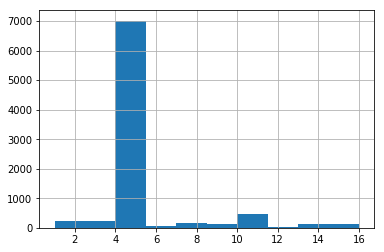

In [20]:
full_record.state.hist()

### Assign state names 

In [21]:
state_name_lut = pd.read_csv("../data/raw/posts_states.csv", sep=";")
state_name_lut.columns = ["state", "state_name"]
state_name_lut.head()

,state,state_name
0,1,Berlin
1,2,Brandenburg
2,3,Baden-Württemberg
3,4,Bayern
4,5,Bremen


In [22]:
full_record = full_record.merge(state_name_lut)

In [23]:
xtick_labels = dict(full_record[["state", "state_name"]].drop_duplicates().values)
print(xtick_labels)

{1: 'Berlin', 2: 'Brandenburg', 3: 'Baden-Württemberg', 4: 'Bayern', 5: 'Bremen', 6: 'Hamburg', 7: 'Hessen', 8: 'Mecklenburg-Vorpommern', 9: 'Niedersachsen', 10: 'Nordrhein-Westfalen', 11: 'Rheinland-Pfalz', 12: 'Saarland', 13: 'Sachsen', 14: 'Sachsen-Anhalt', 15: 'Schleswig-Holstein', 16: 'Thüringen'}


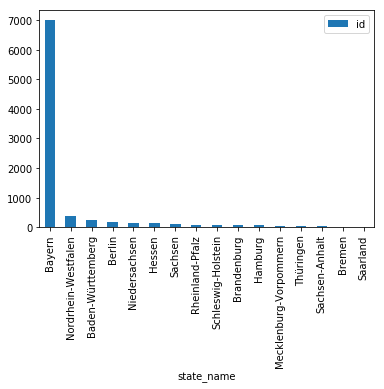

In [24]:
# full_record.state.plot(kind='bar', bins=len(full_record.state.unique()))
# full_record.set_index()
# plt.xticks=[xtick_labels[k] for k in sorted(xtick_labels.keys())]
full_record[["id", "state_name"]].groupby("state_name").aggregate('count').sort_values(by="id", ascending=False).plot.bar()

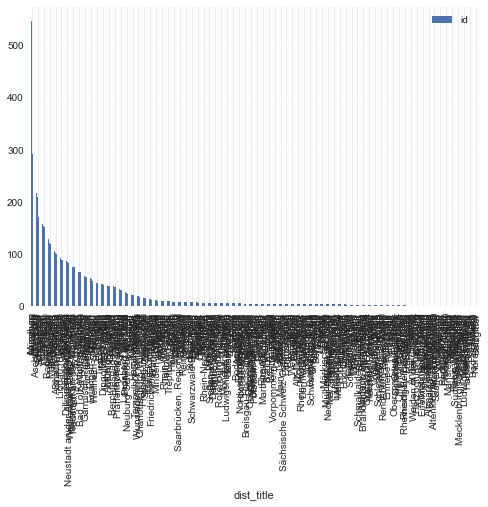

In [25]:
import seaborn as sns
sns.set()
# plt.yscale('log')
full_record[["id", "dist_title"]].groupby("dist_title").aggregate('count').sort_values(by="id", ascending=False).plot.bar() #.sort_values() # .plot.bar()